# Classwork 8 - To πρόβλημα της διαστατικότητας

## 1. Προετοιμασία

Θα χρησιμοποιήσουμε πάλι τα δεδομένα για την ποιότητα του κρασιου και ως συνήθως θα  προσπαθήσουμε να προβλέψουμε την ποιότητα με βάση χαρακτηριστικά όπως παραπάνω ζάχαρη, κιτρικό οξύ κ.λπ.

In [0]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, train_test_split

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
df_wine = pd.read_csv('/gdrive/My Drive/Colab Notebooks/winequality-white.csv', sep=";", header=0)
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [4]:
# κενές τιμές
df_wine.isnull().sum() 

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# 2. Προσθήκη τυχαίων διαστάσεων

Τώρα θα δοκιμάσουμε τι θα συμβεί αν προσθέσουμε τυχαίες διαστάσεις στο σύνολο δεδομένων μας. Αυτό το κάνουμε προσθέτοντας επιπλέον στήλες τυχαίων τιμών στο dataframe μας.

In [0]:
#Δεδομένου ότι θα αλλάξουμε το dataframe μας, δημιουργούμε πρώτα ένα αντίγραφο, έτσι η αρχική μορφή του df_wine παραμένει όπως είναι
df_wine_noise = df_wine.copy()

# Δημιουργία τυχαίων δεδομένων (μέγεθος: όσο το μήκος του dataframe x, όσες διαστάσεις θέλουμε)
random_data = np.random.randn(len(df_wine_noise), 5) #  μπορείτε να αλλάξετε τη δεύτερη τιμή, χρησιμοποιούμε 5 για τώρα

# Μετατρέπουμε τα random data σε ένα df, για να καλέσουμε μετά το function 'df.join' 
random_data = pd.DataFrame(random_data)

# Προσθήκη των δεδομένων που δημιουργήθηκαν με τυχαίες τιμές στο dataframe
df_wine_noise = df_wine_noise.join(random_data)

Μπορούμε να δούμε τις επιπλέον στήλες στο dataframe:

In [6]:
df_wine_noise

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,0,1,2,3,4
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0.230135,0.454685,-0.241500,2.001299,0.223767
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1.498350,0.788594,-0.443910,-0.313426,0.558995
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,-0.536965,0.409805,-0.549905,1.106321,0.868527
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1.417805,-1.214940,-0.598394,-0.955934,1.968815
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,-0.112797,0.036462,0.532877,-0.209394,-2.060742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,-0.912638,-0.510462,0.538021,-1.942175,-2.383410
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1.122304,-2.592388,1.445659,-0.259886,0.453539
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,2.992858,0.072314,-0.875931,1.174879,0.424350
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,-0.287088,0.467642,0.239946,-0.776312,0.354962


# 3. Δοκιμή

Αυτοματοποιούμε τη διαδικασία προσθήκης τυχαίων διαστάσεων στο σύνολο των δεδομένων μας και βλέπουμε πώς επηρεάζει τις προβλέψεις σε διαφορετικά μοντέλα. Χρησιμοποιούμε την ακόλουθη λίστα διαστάσεων για να προσθέσουμε: [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]



*Σε περίπτωση που αναρωτιέστε: στον κώδικα παρακάτω θέτουμε μια τυχαία κατάσταση (random state) πολλές φορές. Με αυτόν τον τρόπο τα ίδια τυχαία δεδομένα δημιουργούνται κάθε φορά. Αυτό μας βοηθά να συγκρίνουμε τα τρία μοντέλα, εφόσον όλα πήραν τα ίδια τυχαία δεδομένα με για είσοδο.*

## 3.1 Γραμμική παλινδρόμηση

Αυτοματοποιούμε τη διαδικασία προσθήκης τυχαίων διαστάσεων στο σύνολο των δεδομένων μας και βλέπουμε πώς επηρεάζει τις προβλέψεις με το μοντέλο γραμμικής παλινδρόμησης. Χρησιμοποιούμε την ακόλουθη λίστα διαστάσεων για να προσθέσουμε: 
[0, 1, 2, 5, 10, 20, 50, 100, 200, 500]

In [0]:
# Προετοιμασία κενής λίστας (συμπληρώνεται με τους μέσους όρους των αποτελέσματων στη συνέχεια) 
ls_r2_test_lin_regr = []
ls_r2_train_lin_regr = []

# δοκιμή διαφορετικού αριθμού τυχαίων διαστάσεων
ls_dim = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]

# Λούπα πάνω από τη λίστα των τυχαίων διαστάσεων
for dimension in ls_dim:
    # Δημιουργία αντιγράφου του πρωτοτύπου df_wine
    df_wine_noise = df_wine.copy()
    # κατασκευάζει τις τυχαίες διαστάσεις (μέγεθος: length of dataframe x current dimensions)
    # Αυτός ο κώδικας είναι απαραίτητος για να δημιουργείτε πάντα τα ίδια τυχαία δεδομένα
    random_data = np.random.RandomState(0).randn(dimension,len(df_wine_noise)).T
    # Μετατρέψτε random_data σε dataframe
    random_data = pd.DataFrame(random_data)
    # Προσθέστε τα δεδομένα που δημιουργήθηκαν με τυχαίες τιμές στο dataframe
    df_wine_noise = df_wine_noise.join(random_data)
    # Δημιουργία Regressor 
    lin_regr = LinearRegression()
    # Ορισμός X και y σε κάθε λούπα, επειδή έχουμε ένα νέο dataframe (με τυχαίες στήλες) σε κάθε λούπα
    X = df_wine_noise.drop(columns='quality')
    y = df_wine_noise.quality
    # 1. Split data σε training και test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
    # 2. Fitting το Regression
    lin_regr.fit(X_train, y_train)
    # 3. Test τον regressor με τα test data (και τα training data για να τα συγκρίνουμε)
    y_pred_test = lin_regr.predict(X_test)
    y_pred_train = lin_regr.predict(X_train)
    # 4. υπολογισμός μετρικών (π.χ. r2)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    # 5. Προσάρτηση του score σε λίστα
    ls_r2_test_lin_regr.append(r2_test)
    ls_r2_train_lin_regr.append(r2_train)

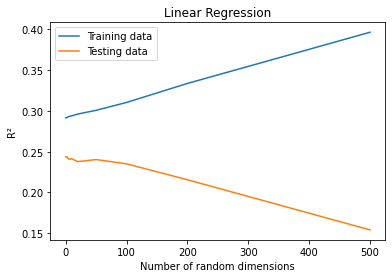

In [14]:
# plot των τιμών R2 στα διαφορετικά depths
plt.plot(ls_dim, ls_r2_train_lin_regr, label="Training data")
plt.plot(ls_dim, ls_r2_test_lin_regr, label="Testing data")
plt.title('Linear Regression')
plt.xlabel('Number of random dimensions')
plt.ylabel('R²')
plt.legend()
plt.show()

## 3.2 Δέντρο αποφάσεων

Αυτοματοποιούμε τη διαδικασία προσθήκης τυχαίων διαστάσεων στο σύνολο των δεδομένων μας και βλέπουμε πώς επηρεάζει τις προβλέψεις με το μοντέλο του δέντρου αποφάσεων. Χρησιμοποιούμε την ακόλουθη λίστα διαστάσεων για να προσθέσουμε: 
[0, 1, 2, 5, 10, 20, 50, 100, 200, 500]

In [0]:
# Προετοιμασία κενής λίστας (συμπληρώνεται με τους μέσους όρους των αποτελέσματων στη συνέχεια) 
ls_r2_test_dec_tree = []
ls_r2_train_dec_tree = []

# δοκιμή διαφορετικού αριθμού τυχαίων διαστάσεων
ls_dim = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]

# Λούπα πάνω από τη λίστα των τυχαίων διαστάσεων
for dimension in ls_dim:
    # Δημιουργία αντιγράφου του πρωτοτύπου df_wine
    df_wine_noise = df_wine.copy()
    # κατασκευάζει τις τυχαίες διαστάσεις (μέγεθος: length of dataframe x current dimensions)
    # Αυτός ο κώδικας είναι απαραίτητος για να δημιουργείτε πάντα τα ίδια τυχαία δεδομένα
    random_data = np.random.RandomState(0).randn(dimension,len(df_wine_noise)).T
    # Μετατρέψτε random_data σε dataframe
    random_data = pd.DataFrame(random_data)
    # Προσθέστε τα δεδομένα που δημιουργήθηκαν με τυχαίες τιμές στο dataframe
    df_wine_noise = df_wine_noise.join(random_data)
    # Δημιουργία του Regressor, με max_depth=6, αφού στην άσκηση 6 αυτό ήταν το βέλτιστο
    dec_tree = DecisionTreeRegressor(max_depth=6)
    # Ορισμός X και y σε κάθε λούπα, επειδή έχουμε ένα νέο dataframe (με τυχαίες στήλες) σε κάθε λούπα
    X = df_wine_noise.drop(columns='quality')
    y = df_wine_noise.quality
    # 1. Split data σε training και test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
    # 2. Fitting το Regression
    dec_tree.fit(X_train, y_train)
    # 3. Test τον regressor με τα test data (και τα training data για να τα συγκρίνουμε)
    y_pred_test = dec_tree.predict(X_test)
    y_pred_train = dec_tree.predict(X_train)
    # 4. υπολογισμός μετρικών (π.χ. r2)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    # 5. Προσάρτηση του score σε λίστα
    ls_r2_test_dec_tree.append(r2_test)
    ls_r2_train_dec_tree.append(r2_train)

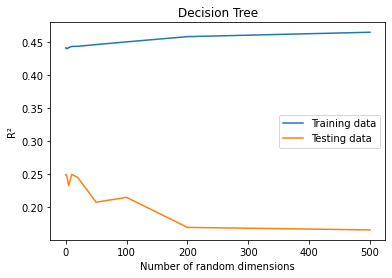

In [16]:
# plot των τιμών R2 στα διαφορετικά depths
plt.plot(ls_dim, ls_r2_train_dec_tree, label="Training data")
plt.plot(ls_dim, ls_r2_test_dec_tree, label="Testing data")
plt.title('Decision Tree')
plt.xlabel('Number of random dimensions')
plt.ylabel('R²')
plt.legend()
plt.show()

## 3.3 Τυχαίο Δάσος
Αυτοματοποιούμε τη διαδικασία προσθήκης τυχαίων διαστάσεων στο σύνολο των δεδομένων μας και βλέπουμε πώς επηρεάζει τις προβλέψεις με το μοντέλο του τυχαίου δάσους. Χρησιμοποιούμε την ακόλουθη λίστα διαστάσεων για να προσθέσουμε: 
[0, 1, 2, 5, 10, 20, 50, 100, 200, 500]

In [0]:
# Προετοιμασία κενής λίστας (συμπληρώνεται με τους μέσους όρους των αποτελέσματων στη συνέχεια)  
ls_r2_test_rf_regr = []
ls_r2_train_rf_regr = []

# δοκιμή διαφορετικού αριθμού τυχαίων διαστάσεων
ls_dim = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500] 

# Λούπα πάνω από τη λίστα των τυχαίων διαστάσεων
for dimension in ls_dim:
    # Δημιουργία αντιγράφου του πρωτοτύπου df_wine
    df_wine_noise = df_wine.copy()
    # κατασκευάζει τις τυχαίες διαστάσεις (μέγεθος: length of dataframe x current dimensions)
    # Αυτός ο κώδικας είναι απαραίτητος για να δημιουργείτε πάντα τα ίδια τυχαία δεδομένα
    random_data = np.random.RandomState(0).randn(dimension,len(df_wine_noise)).T
    # Μετατρέψτε random_data σε dataframe
    random_data = pd.DataFrame(random_data)
    # Προσθέστε τα δεδομένα που δημιουργήθηκαν με τυχαίες τιμές στο dataframe
    df_wine_noise = df_wine_noise.join(random_data)
    # Δημιουργία του Regressor, περιορίζει τα n_estimators μόνο για τη μείωση του χρόνου υπολογισμού
    rf_regr = RandomForestRegressor(n_estimators=20)
    # Ορισμός X και y σε κάθε λούπα, επειδή έχουμε ένα νέο dataframe (με τυχαίες στήλες) σε κάθε λούπα
    X = df_wine_noise.drop(columns='quality')
    y = df_wine_noise.quality
    # 1. Split data σε training και test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
    # 2. Fitting το Regression
    rf_regr.fit(X_train, y_train)
    # 3. Test τον regressor με τα test data (και τα training data για να τα συγκρίνουμε)
    y_pred_test = rf_regr.predict(X_test)
    y_pred_train = rf_regr.predict(X_train)
    # 4. Yπολογισμός μετρικών (π.χ. r2)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    # 5. Προσάρτηση του score σε λίστα
    ls_r2_test_rf_regr.append(r2_test)
    ls_r2_train_rf_regr.append(r2_train)

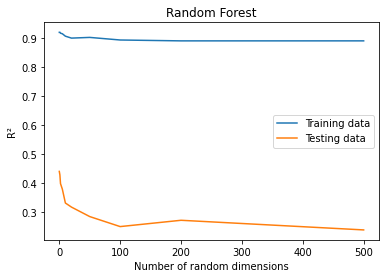

In [18]:
# plot των τιμών R2 στα διαφορετικά depths
plt.plot(ls_dim, ls_r2_train_rf_regr, label="Training data")
plt.plot(ls_dim, ls_r2_test_rf_regr, label="Testing data")
plt.title('Random Forest')
plt.xlabel('Number of random dimensions')
plt.ylabel('R²')
plt.legend()
plt.show()

Τα αποτελέσματα δείχνουν ότι οι διάστασεις εισόδου που δεν φέρουν σημαντικές πληροφορίες (μόνο τυχαία δεδομένα) θα επιδεινώσει τα αποτελέσματα των προβλέψεών μας. Βλέπουμε επίσης ότι ορισμένες μέθοδοι είναι πιο ευαίσθητες από άλλες. Δηλαδή, η πρόβλεψη του δέντρου αποφάσεων πέφτει πολύ γρήγορα με τον αριθμό των διαστάσεις εισόδου που δεν φέρουν κανένα νόημα, ενώ η γραμμική παλινδρόμηση είναι πιο ανθεκτική και πέφτει πιο αργά. Ωστόσο, και οι δύο μέθοδοι φτάνουν σε 0.15 R² με 500 τυχαίες διαστάσεις. Το τυχαίο δάσος αποδεικνύεται ως η πιο ανθεκτική (robust) μέθοδος. Ακόμη και με 500 τυχαίες διαστάσεις εισόδου, η μέθοδος μπορεί να επιτύχει περίπου 0,25 R².

# 4. Άσκηση


Για την επόμενη φορά θα έχετε δύο ασκήσεις. Μπορείτε να τις λύσετε **σε αυτό το notebook**, δεν χρειάζεται να δημιουργήσετε ένα νέο.

 - Προσθέστε 1000 και περισσότερες διαστάσεις και στα τρία μοντέλα και εκτελέστε τα. 

 - Δημιουργήστε ένα νέο plot με τα αποτελέσματα (μόνο τα testing data χρειάζονται) και των τριών διαφορετικών μοντέλων στο ίδιο γράφημα. Βοήθεια: Ο κώδικας είναι ακριβώς ο ίδιος με επάνω, οπότε πρακτικά έχετε ήδη έτοιμα τα  R² values και σωσμένα σε λίστες. Δεν χρειάζεται να υπολογίζετε νέες τιμές για το plot. Γράψτε μια παράγραφο με τα αποτελέσματά σας.